<a href="https://colab.research.google.com/github/51rL1N5/Prova_Esig/blob/master/taxi_fare.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import numpy as np
import seaborn as sbs
from haversine import haversine
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [0]:
# Como o banco de dados é muito grnade, irei analizar-lo por blocos
# Que são suficientemente grandes para podermos supor que representam bem uma aproximação
# da estatística global.

# Logo após processar todos eles, é necessário fazer uma média das análises (estacionaridade)


chunksize = 10 ** 6

chunk = pd.read_csv('train.csv', nrows=chunksize)

In [135]:
# Olhando a cara dos dados

chunk.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1


In [0]:
# Primeiro, vamos limpar os dados 

"""
----- Limpeza de coordenadas -------------

Sei que a latitude é um número limitado entre -90 <= lat <= 90  
Bem como a longitude é limitada entre -180 <= long <= 180

Então, irei eliminar dados que apresentarem esses dados expúrios

"""

chunk = chunk[
               ( abs(chunk['pickup_latitude']) <= 90 ) & ( abs(chunk['pickup_longitude']) <= 180 ) & ( abs(chunk['dropoff_latitude']) <= 90 ) & ( abs(chunk['dropoff_longitude']) <= 180 )
             ]

"""
----- Limpeza de taxas -------------------

Não faz sentido que tenhamos preço pago negativo
Logo, eliminaremos os dados que possuam tal característica

"""

chunk = chunk[
               (chunk['fare_amount'] >= 0)
             ]

"""
----- Limpeza do número de passageiros ------

De acordo com https://www1.nyc.gov/nyc-resources/faq/484/how-many-passengers-are-allowed-in-a-taxi

No máximo 4 ou 5, acrescido de uma criança abaixo de 7 anos (que ficará no colo de um adulto) poderão ir no taxi

Logo, no máximo teremos 6 passageiros
"""

chunk = chunk[
               (chunk['passenger_count'] <=6)
             ]

"""
----- Remover, caso existam, dados nulos (faltantes) -------------
"""
chunk = chunk.drop(chunk[chunk.isnull().any(1)].index, axis=0)

In [137]:
# Agora, criaremos um indicador de distancia percorrida, bem como criarei mais colunas
# Com mais informação util, como Dia, Mês, Ano, hora, minuto, segundo


# Para calcularmos a distancia, se faz necessário usar a formula de haversine que pega dois pontos em uma esfera (latitude e longitude) e converte para distancia em metros

def haversine_1 (lat1, long1, lat2, long2):
  
  # Lambda é a longitude
  # Phi é a latitude
  R = 6371 # raio da terra em km

  phi_1 = np.radians(chunk[lat1])
  phi_2 = np.radians(chunk[lat2])

  delta_phi    = np.radians(chunk[lat2] - chunk[lat1])
  delta_lambda = np.radians(chunk[long2] - chunk[long1])

  #a = sin²((φB - φA)/2) + cos φA . cos φB . sin²((λB - λA)/2)
  a = np.sin(delta_phi / 2.0) ** 2 + np.cos(phi_1) * np.cos(phi_2) * np.sin(delta_lambda / 2.0) ** 2

  #c = 2 * atan2( √a, √(1−a) )
  c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))


  #d = R*c
  d = (R * c) # distancia em km

  chunk['distancia'] = d 
  return d
                                 

haversine_1('pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude')

0          1.030764
1          8.450134
2          1.389525
3          2.799270
4          1.999157
5          3.787239
6          1.555807
7          4.155444
8          1.253232
9          2.849627
10         1.374577
11         0.000000
12         0.717767
13         2.019384
14         1.671445
15         0.000000
16         2.609774
17         1.511904
18         0.921952
19         0.399179
20         1.686861
21         2.292470
22         0.924296
23         1.403958
24         1.017773
25         2.531947
26         0.000000
27         0.328771
28         4.073463
29         0.808153
            ...    
999970     1.800660
999971    16.888650
999972     0.443274
999973     0.509990
999974     6.774274
999975     9.357706
999976     4.093045
999977     5.314221
999978     1.842736
999979     3.689741
999980     4.456025
999981     3.622864
999982     1.162477
999983     0.806466
999984     8.401025
999985     1.344648
999986     0.821492
999987     0.240398
999988     0.000000


In [0]:
# converter string para date_time, para obtermos os dados temporais

chunk['key']             = pd.to_datetime(chunk['key'])

chunk['pickup_datetime'] = pd.to_datetime(chunk['pickup_datetime'])

In [139]:
# Olhando a cara dos atributos dos dados após a conversão

chunk.dtypes

key                  datetime64[ns]
fare_amount                 float64
pickup_datetime      datetime64[ns]
pickup_longitude            float64
pickup_latitude             float64
dropoff_longitude           float64
dropoff_latitude            float64
passenger_count               int64
distancia                   float64
dtype: object

In [0]:
# Separando os dados temporais para podermos visualizar-los melhor

chunk['Ano'] = chunk['pickup_datetime'].dt.year
chunk['Mes'] = chunk['pickup_datetime'].dt.month
chunk['Dia'] = chunk['pickup_datetime'].dt.day
chunk['Dia da semana'] = chunk['pickup_datetime'].dt.dayofweek
chunk['Horario'] = chunk['pickup_datetime'].dt.hour

# **Análise exploratória de dados**

---



**Como é cobrada a taxa de taxi em NYC:**

1 - A taxa inicial é de **$2.50**

2 - Mais  **50 cents ** a cada 1/5 de Milha (0,321869 km) acima de 12 mph (19,3121 km/h) ou a cada minuto em tráfico devagar

3 - **50 cents**  de taxa adicional para todas viagens que terminam em NYC, Nassau, Suffolk, Westchester, Rockland, Dutchess, Orange ou Putnam Counties

4 - ** 30 cents** de taxa de melhoramento

5 - ** 50 cents ** de taxa para tráfego entre **8pm** e **6am**

6 - ** $1.00 ** de taxa de hora do rush (**4pm ate 8pm**) em dias de semana, não se aplicando a feriados

7 -  Taxa de congestionamento de ** 2.50 ** (Taxi amarelo) , ** 2.75** (Taxi verde ou FHV) ou **75 cents** para corridas compartilhadas para todas as corridas que começam, terminam ou passam por Manhattan south of 96th street

8 - Pedágios e gorjetas são acrescidos caso necessário

**Hipóteses:**

1 - O Número de pessoas impacta no valor da taxa

2 - O horário o qual o taxi foi pego impacta no valor

3 - O dia da semana o qual o taxi foi pego impacta no valor

4 - O Taxi foi pego em um aeroporto, onde a taxa é maior

5 - Os meses impactam no valor da taxa?

6 - A distância percorrida impacta no valor da taxa



##**Hipótese 1**

---
O número de pessoas impacta no valor da taxa?


0

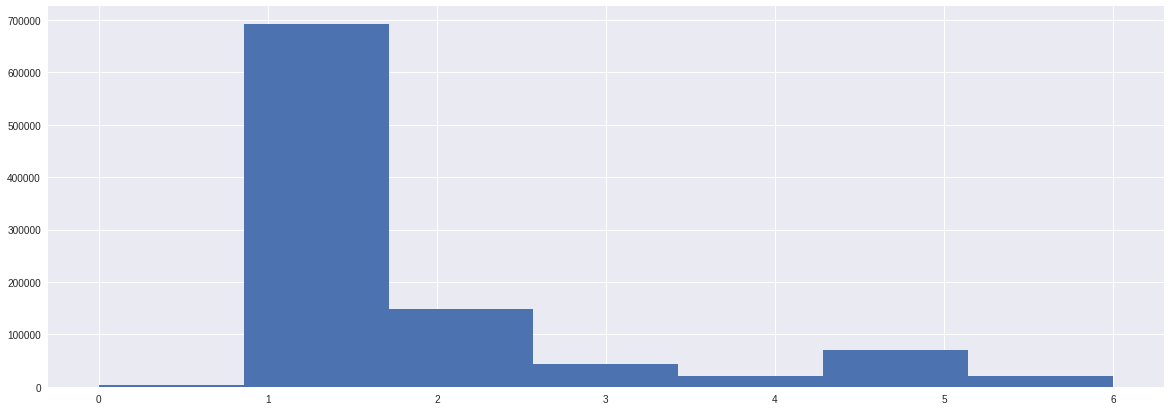

In [143]:
# Inicialmente, vamos ver a distribuição do número de pessoas

plt.figure(figsize=(20,7))

chunk['passenger_count'].hist(bins=7)

Text(0, 0.5, 'Taxa paga')

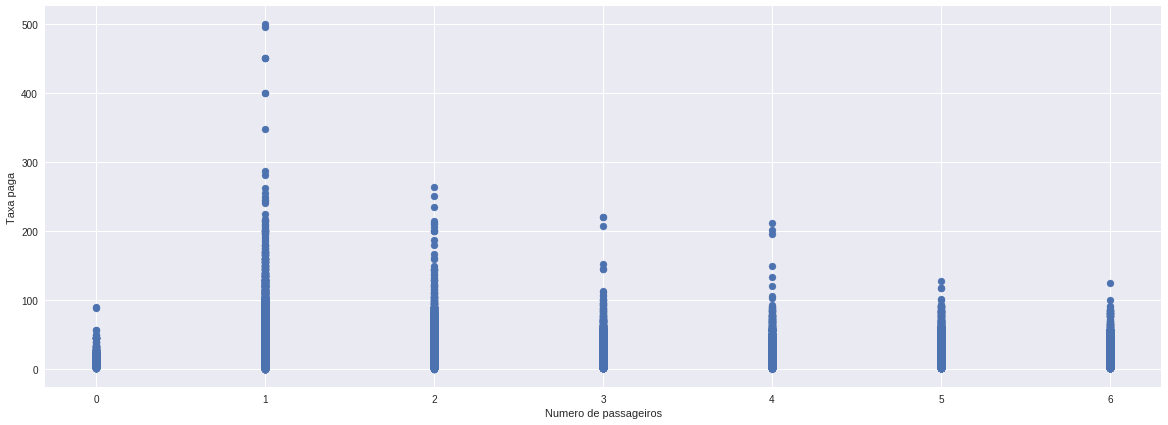

In [145]:
# Agora, é interessante ver como está a distribuição de número de passageiros x taxa paga

plt.figure(figsize=(20,7))

plt.scatter(x=chunk['passenger_count'], y=chunk['fare_amount'])
plt.xlabel('Numero de passageiros')
plt.ylabel('Taxa paga')

Dos dois gráficos, podemos inferir que a viagem de taxi para 1 passageiro é mais frequente. As taxas pagas mais altas também vem da viagem para 1 passageiro

#**Hipótese 2**

---

O horário impacta na taxa paga?